In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import needed packages
import cv2
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D,Dropout,SeparableConv2D,BatchNormalization, Activation, Dense
from keras.applications.mobilenet import MobileNet
from keras.optimizers import Adam

In [ ]:
num_class = 36

# Base model without Fully connected Layers
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224,224,3))
x=base_model.output
# Add some new Fully connected layers to 
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x = Dropout(0.25)(x)
x=Dense(512,activation='relu')(x) 
x = Dropout(0.25)(x)
preds=Dense(num_class, activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=preds)

17227776/17225924 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [ ]:
for i,layer in enumerate(model.layers):
  print("{}: {}".format(i,layer))

0: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f52dce3c160>
1: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f52dce3d7f0>
2: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f52dce3dcf8>
3: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f52a9984978>
4: <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f52a9984f28>
5: <tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f52a910f278>
6: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f52a0326b70>
7: <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f52a02ae5c0>
8: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f52a02ae1d0>
9: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f52a02d0860>
10: <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f52a02d0c18>
11: <tensorflow.pyt

In [ ]:
for layer in model.layers[:87]:
    layer.trainable=False
for layer in model.layers[87:]:
    layer.trainable=True

In [ ]:
train_datagen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input,
                                 validation_split=0.25)

train_generator=train_datagen.flow_from_directory('/content/drive/My Drive/Minor project-ISL detection/OUR_ISL dataset/',
                                                 target_size=(224,224),
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 subset='training')


validation_generator = train_datagen.flow_from_directory(
                                                '/content/drive/My Drive/Minor project-ISL detection/OUR_ISL dataset/', # same directory as training data
                                                target_size=(224,224),
                                                batch_size=64,
                                                class_mode='categorical',
                                                subset='validation') # set as validation data

Found 1620 images belonging to 36 classes.
Found 539 images belonging to 36 classes.


In [ ]:
epochs = 50
learning_rate = 0.0005
decay_rate = learning_rate / epochs
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

!mkdir ckpt
!mkdir logs

filepath="ckpt/best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only = False, save_best_only=True, mode='min')
logdir="logs/mobilenet"
tfboard = TensorBoard(log_dir=logdir)

callbacks_list = [checkpoint, tfboard]


In [ ]:
step_size_train = train_generator.n/train_generator.batch_size
step_size_val = validation_generator.samples // validation_generator.batch_size
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator, 
                   validation_steps =step_size_val,
                   callbacks = callbacks_list,
                   epochs=10)
model.save('ISL_Mobilenet.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
 1/25 [>.............................] - ETA: 0s - loss: 3.6466 - accuracy: 0.0781WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
26/25 [==============================] - ETA: -24s - loss: 2.3651 - accuracy: 0.4228
Epoch 00001: val_loss improved from inf to 1.18756, saving model to ckpt/best.hdf5
26/25 [==============================] - 1213s 47s/step - loss: 2.3651 - accuracy: 0.4228 - val_loss: 1.1876 - val_accuracy: 0.7852
Epoch 2/10
26/25 [==============================] - ETA: -4s - loss: 0.5268 - accuracy: 0.8907
Epoch 00002: val_loss improved from 1.18756 to 0.28771, saving model to ckpt/best.hdf5
26/25 [==============================] - 199s 8s/step - loss: 0.5268 - 

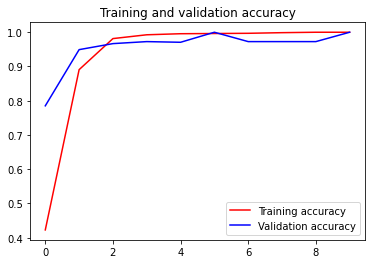

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()



plt.show()

<Figure size 432x288 with 0 Axes>

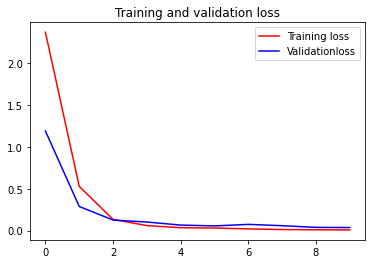

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validationloss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

Testing the model

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D,Dropout,SeparableConv2D,BatchNormalization, Activation, Dense
from keras.applications.mobilenet import MobileNet
from keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/Models/ISL_Mobilenet.h5')

In [ ]:
train_datagen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input,
                                 validation_split=0.25)

train_generator=train_datagen.flow_from_directory('/content/drive/My Drive/Minor project-ISL detection/OUR_ISL dataset/',
                                                 target_size=(224,224),
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 subset='training')


validation_generator = train_datagen.flow_from_directory(
                                                '/content/drive/My Drive/Minor project-ISL detection/OUR_ISL dataset/', # same directory as training data
                                                target_size=(224,224),
                                                batch_size=64,
                                                class_mode='categorical',
                                                subset='validation') # set as validation data

Found 1631 images belonging to 36 classes.
Found 542 images belonging to 36 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


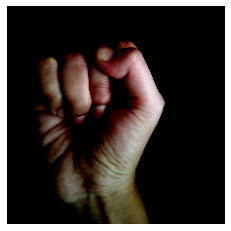

True label: 0
Predicted label: 0


In [ ]:
import matplotlib.pyplot as plt
def get_class_string_from_index(index):
   for class_string, class_index in validation_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(validation_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [ ]:
import cv2
import tensorflow as tf

CATEGORIES= ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
def prepare(filepath):
    IMG_SIZE=224
    img_array=cv2.imread(filepath)
    img_array = img_array / 255.0
    new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
    return new_array.reshape(-1,IMG_SIZE,IMG_SIZE,3)


prediction = model.predict(prepare('/content/drive/My Drive/Minor project-ISL detection/OUR_ISL dataset/S/S (49).jpg'))
prediction = np.argmax(prediction,-1)

print(prediction)
print(CATEGORIES[int(prediction[0])])

[28]
S


Found 1620 images belonging to 36 classes.
Found 2159 images belonging to 36 classes.
34/34 [==============================] - 656s 19s/step
[[60  0  0 ...  0  0  0]
 [ 0 60  0 ...  0  0  0]
 [ 0  0 60 ...  0  0  0]
 ...
 [ 0  0  0 ... 60  0  0]
 [ 0  0  0 ...  0 60  0]
 [ 0  0  0 ...  0  0 60]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        60
           2       1.00      1.00      1.00        60
           3       1.00      1.00      1.00        60
           4       1.00      1.00      1.00        60
           5       1.00      1.00      1.00        60
           6       1.00      1.00      1.00        60
           7       1.00      1.00      1.00        60
           8       1.00      1.00      1.00        60
           9       1.00      1.00      1.00        60
           A       1.00      1.00      1.00        60
           B       1.00      1.00      1.00        60


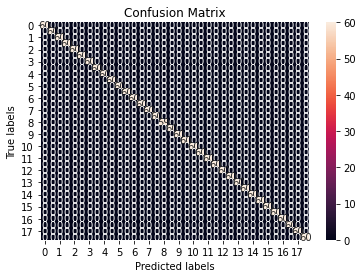

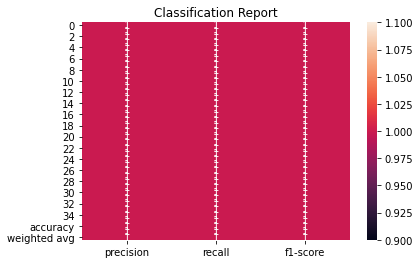

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns
import math 
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
batch_size=64
target_size=(224,224)
#Calling the saved model for making predictions
train_datagen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input,
                                 validation_split=0.25)

train_generator=train_datagen.flow_from_directory('/content/drive/My Drive/Minor project-ISL detection/OUR_ISL dataset/',
                                                 target_size=(224,224),
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 subset='training')
validation_generator = train_datagen.flow_from_directory(
                 '/content/drive/My Drive/Minor project-ISL detection/OUR_ISL dataset/',
                 target_size=target_size, 
                 batch_size=batch_size,
                 class_mode=None,
                 shuffle=False)
validation_generator.reset()
model = tf.keras.models.load_model('/content/drive/My Drive/Models/ISL_Mobilenet.h5')

pred=model.predict(validation_generator,
                            verbose=1)

predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=validation_generator.filenames
a={"Filename":filenames,"Predictions":predictions}
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
#create a function for visualizing model performance 

def PerformanceReports(conf_matrix,class_report,labels):
    ax= plt.subplot()
    sns.heatmap(conf_matrix, annot=True,ax=ax)
    #labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()
    ax= plt.subplot()
    sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T,  
                annot=True,ax=ax)
    ax.set_title('Classification Report')
    plt.show()
    from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
    labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
test_labels = [fn.split('/')[0] for fn in filenames]

cm=confusion_matrix(test_labels,predictions)
print(cm)
cr=classification_report(test_labels, predictions)
class_report=classification_report(test_labels, predictions,
                                   target_names=labels,
                                   output_dict=True)
print(cr)
PerformanceReports(cm,class_report,labels)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          output_file,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(24, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(output_file)
    plt.show()
  

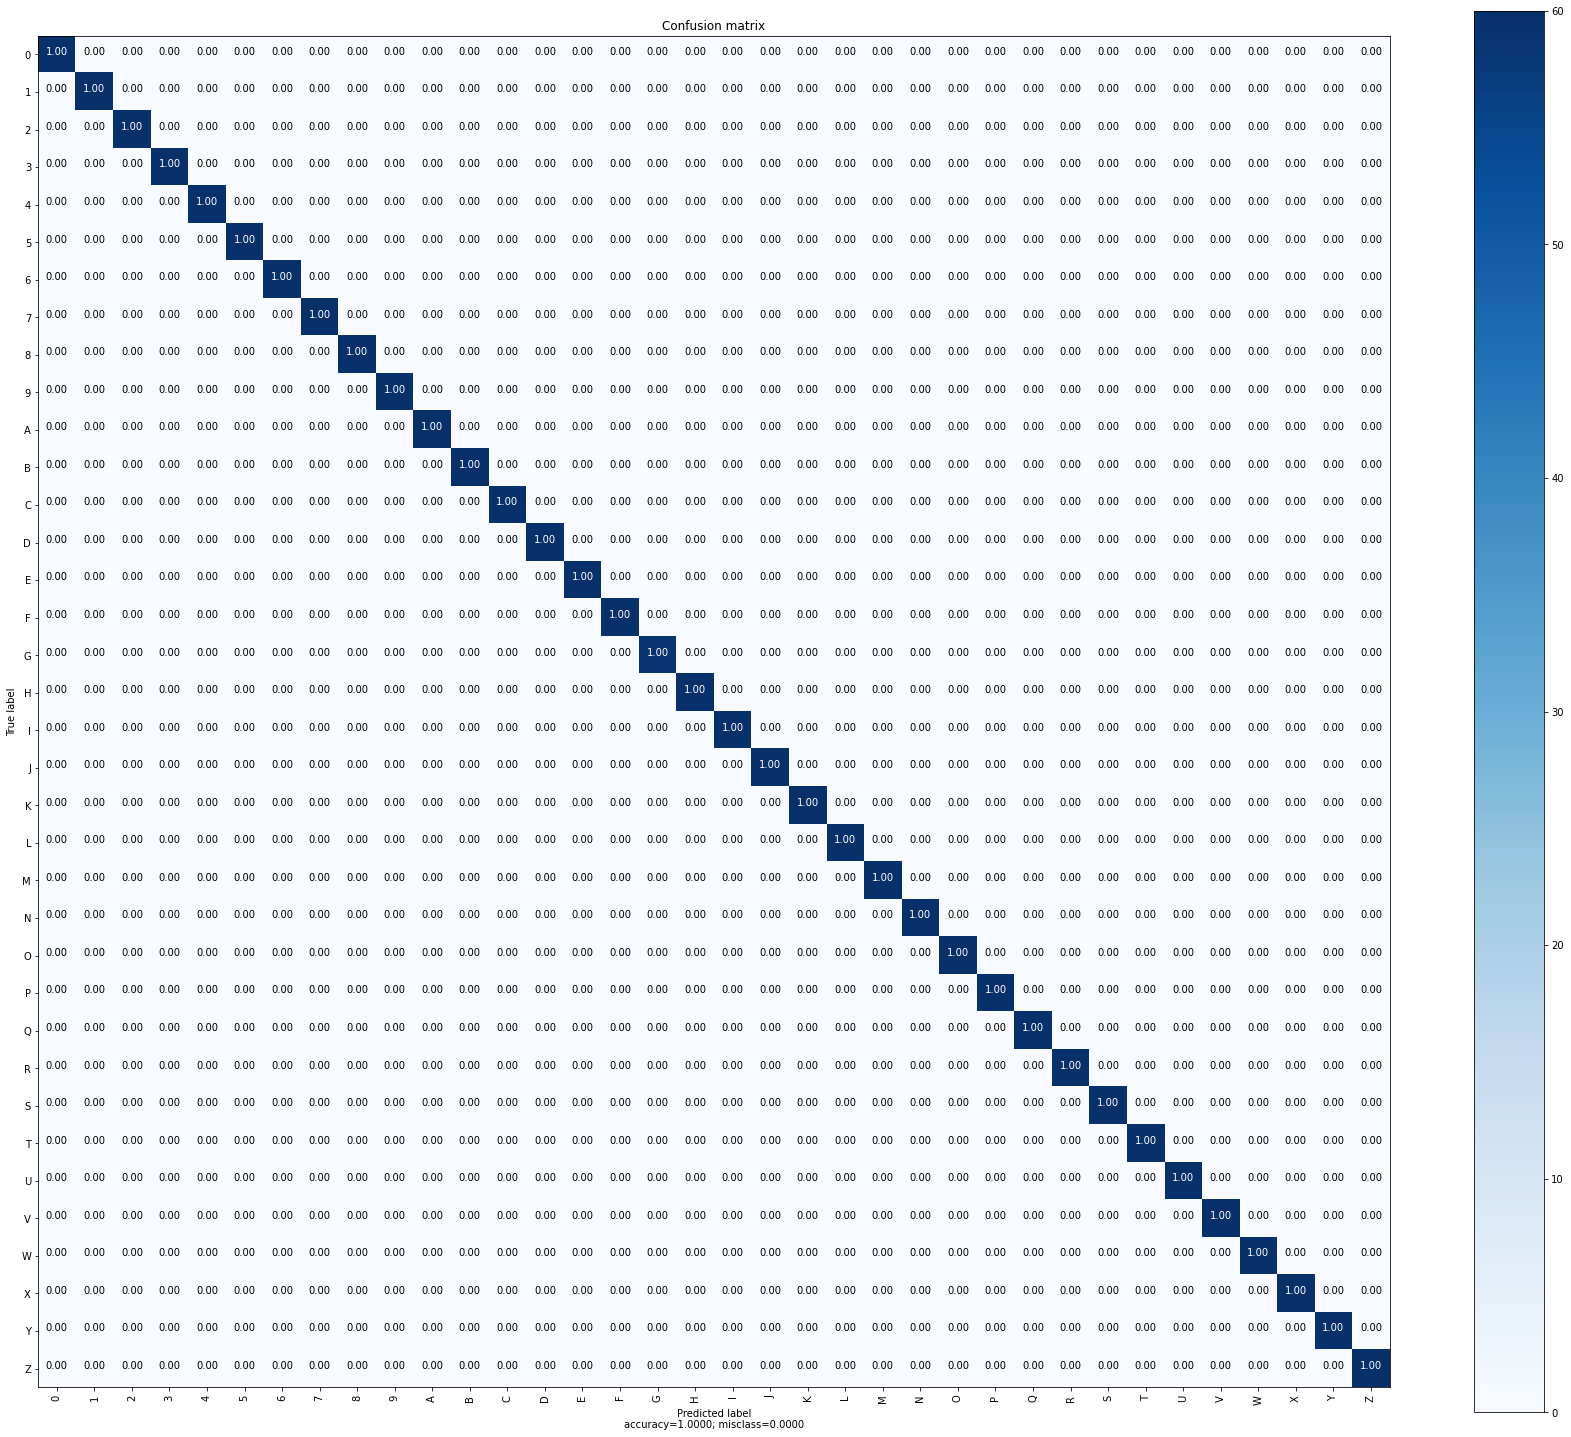

In [ ]:
#Plotting the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

#Defining the class labels
class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
output_file='/content/drive/My Drive/'
# Plotting non-normalized confusion matrix
plot_confusion_matrix(cm, class_names, output_file, title='Confusion matrix')

Converting the model to json and bin file for deploying in mobile platform 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import keras

from tensorflow import keras
from keras import backend as K
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D,Dropout,SeparableConv2D,BatchNormalization, Activation, Dense
from keras.applications.mobilenet import MobileNet
from keras.optimizers import Adam

In [ ]:
pip install tensorflowjs


     |████████████████████████████████| 71kB 3.9MB/s 
     |████████████████████████████████| 112kB 7.4MB/s 
  Found existing installation: tensorflow-hub 0.10.0
    Uninstalling tensorflow-hub-0.10.0:
      Successfully uninstalled tensorflow-hub-0.10.0


In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/Models/ISL_Mobilenet.h5')

In [ ]:

!tensorflowjs_converter --input_format keras ISL_Mobilenet.h5 model/


mkdir: cannot create directory ‘model/’: File exists
2020-12-02 08:01:55.777472: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [ ]:
!zip -r my_model.zip my_model 

  adding: my_model/ (stored 0%)
  adding: my_model/group1-shard2of5.bin (deflated 7%)
  adding: my_model/group1-shard3of5.bin (deflated 7%)
  adding: my_model/group1-shard5of5.bin (deflated 8%)
  adding: my_model/group1-shard4of5.bin (deflated 8%)
  adding: my_model/group1-shard1of5.bin (deflated 7%)
  adding: my_model/model.json (deflated 94%)


In [ ]:
from google.colab import files
files.download('my_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>